In [1]:
%matplotlib widget

import json

import pandas as pd
import matplotlib.pyplot as plt
import wandb

DF_CACHE = {}
CACHE = False

In [2]:
WIN_RATE = "interim_training/eval_T0.25/win_rate"
LOSS = "direct/loss/total"
ACQ = "acquire_pairs_function"

def load_data(project, tag):
    all_dfs = []
    for run in wandb.Api().runs(project):
        if tag in run.tags:
            print(run.name, run.state)
            cfg = json.loads(run.json_config)
            df = DF_CACHE.get(run.id)
            if df is None:
                df = pd.DataFrame(run.scan_history())
                cols = ["step", "m", "epoch", LOSS, WIN_RATE]
                if all(c in df.columns for c in cols):
                    df = df[cols]
                    df['m'] = df['m'].fillna(method="ffill")
                    df[LOSS] = df[LOSS].fillna(method="ffill")
                    df['epoch'] = df['epoch'].fillna(method="ffill")
                    df['epoch'] = df['epoch'].interpolate().astype(int)
                    df["m"] = df["m"].astype(int)
                    df["epoch"] = df["epoch"].astype(int)
                    df["acquire_pairs_function"] = cfg["exp5"]["value"][ACQ]
                    df["seed"] = int(cfg["seed"]["value"])
                    df = df[df["epoch"] < 100.0]
                    if run.state == "finished" and CACHE:
                        DF_CACHE[run.id] = df

            all_dfs.append(df)

    df = pd.concat(all_dfs)
    df = df[df.m <= 1024]
    return df

def plot(df, title, filename):
    m_s = sorted(set(df['m']))
    fig, axs = plt.subplots(len(m_s), 1, figsize=(7, len(m_s) * 2.5))

    for i, m in enumerate(m_s):
        loss_df = df.groupby(["epoch", "m"])[LOSS].mean().unstack()[m]
        win_df = df.groupby(["epoch", "m"])[WIN_RATE].mean().unstack()[m].dropna()
        ax1 = axs[i]
        ax2 = ax1.twinx()

        ln1 = ax1.plot(loss_df, label=f"training-loss, m={m}", linestyle='-.')[0]
        ax1.set_ylabel(f"training-loss")
        ln2 = ax2.plot(win_df, label=f"win-rate, m={m}")[0]
        ax2.set_ylabel(f"win-rate", rotation=-90, labelpad=15)
        ax2.set_ylim(0.5, 0.9)
        ax1.set_xlabel("epoch")
        #plt.legend()

        # lns = lns1+lns2+lns3
        # labs =
        ax1.legend([ln1, ln2], [ln1.get_label(), ln2.get_label()])
        plt.plot()

    fig.suptitle(title)
    fig.tight_layout()

    fig.savefig(filename)


In [3]:
tldr_data = load_data("bbnn/wm-apl-tldr-convergence", "tldr-exp5-convergence1")

effortless-cosmos-15 killed
hearty-river-14 finished
ethereal-frog-13 finished
balmy-wood-12 finished
stellar-snowball-10 finished
ethereal-meadow-9 killed
lyric-music-8 killed


In [4]:
imdb_data = load_data("bbnn/wm-apl-imdb-convergence", "exp5")

stoic-mountain-10 finished
fanciful-spaceship-9 finished
stoic-tree-8 finished
drawn-terrain-7 finished
visionary-lion-6 finished


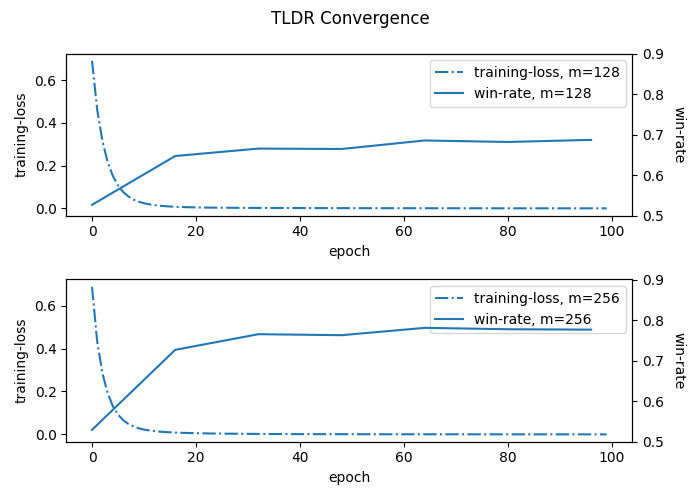

In [5]:
plot(tldr_data, "TLDR Convergence", "tldr-convergence.png")

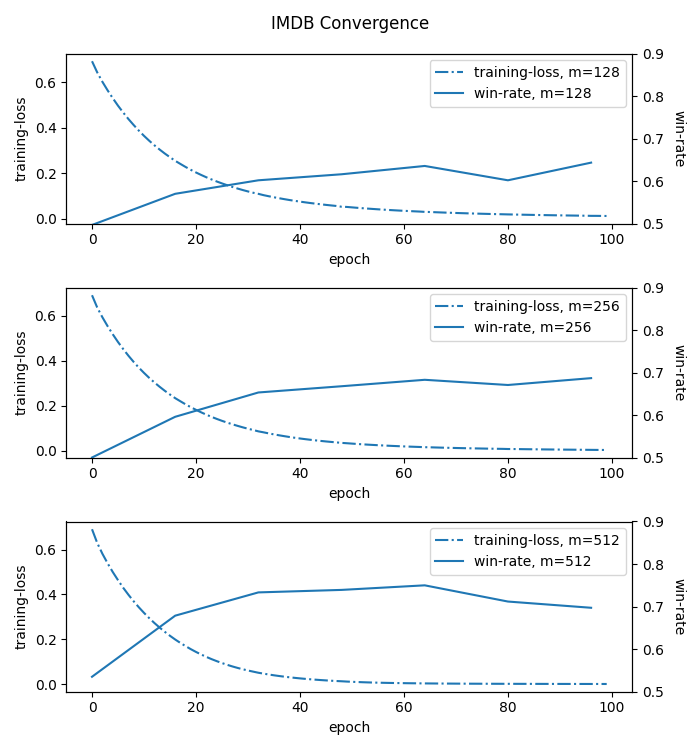

In [6]:
plot(imdb_data, "IMDB Convergence", "imdb-convergence.png")